In [17]:
import matplotlib
%matplotlib inline
matplotlib.style.use('default')
import seaborn as sns

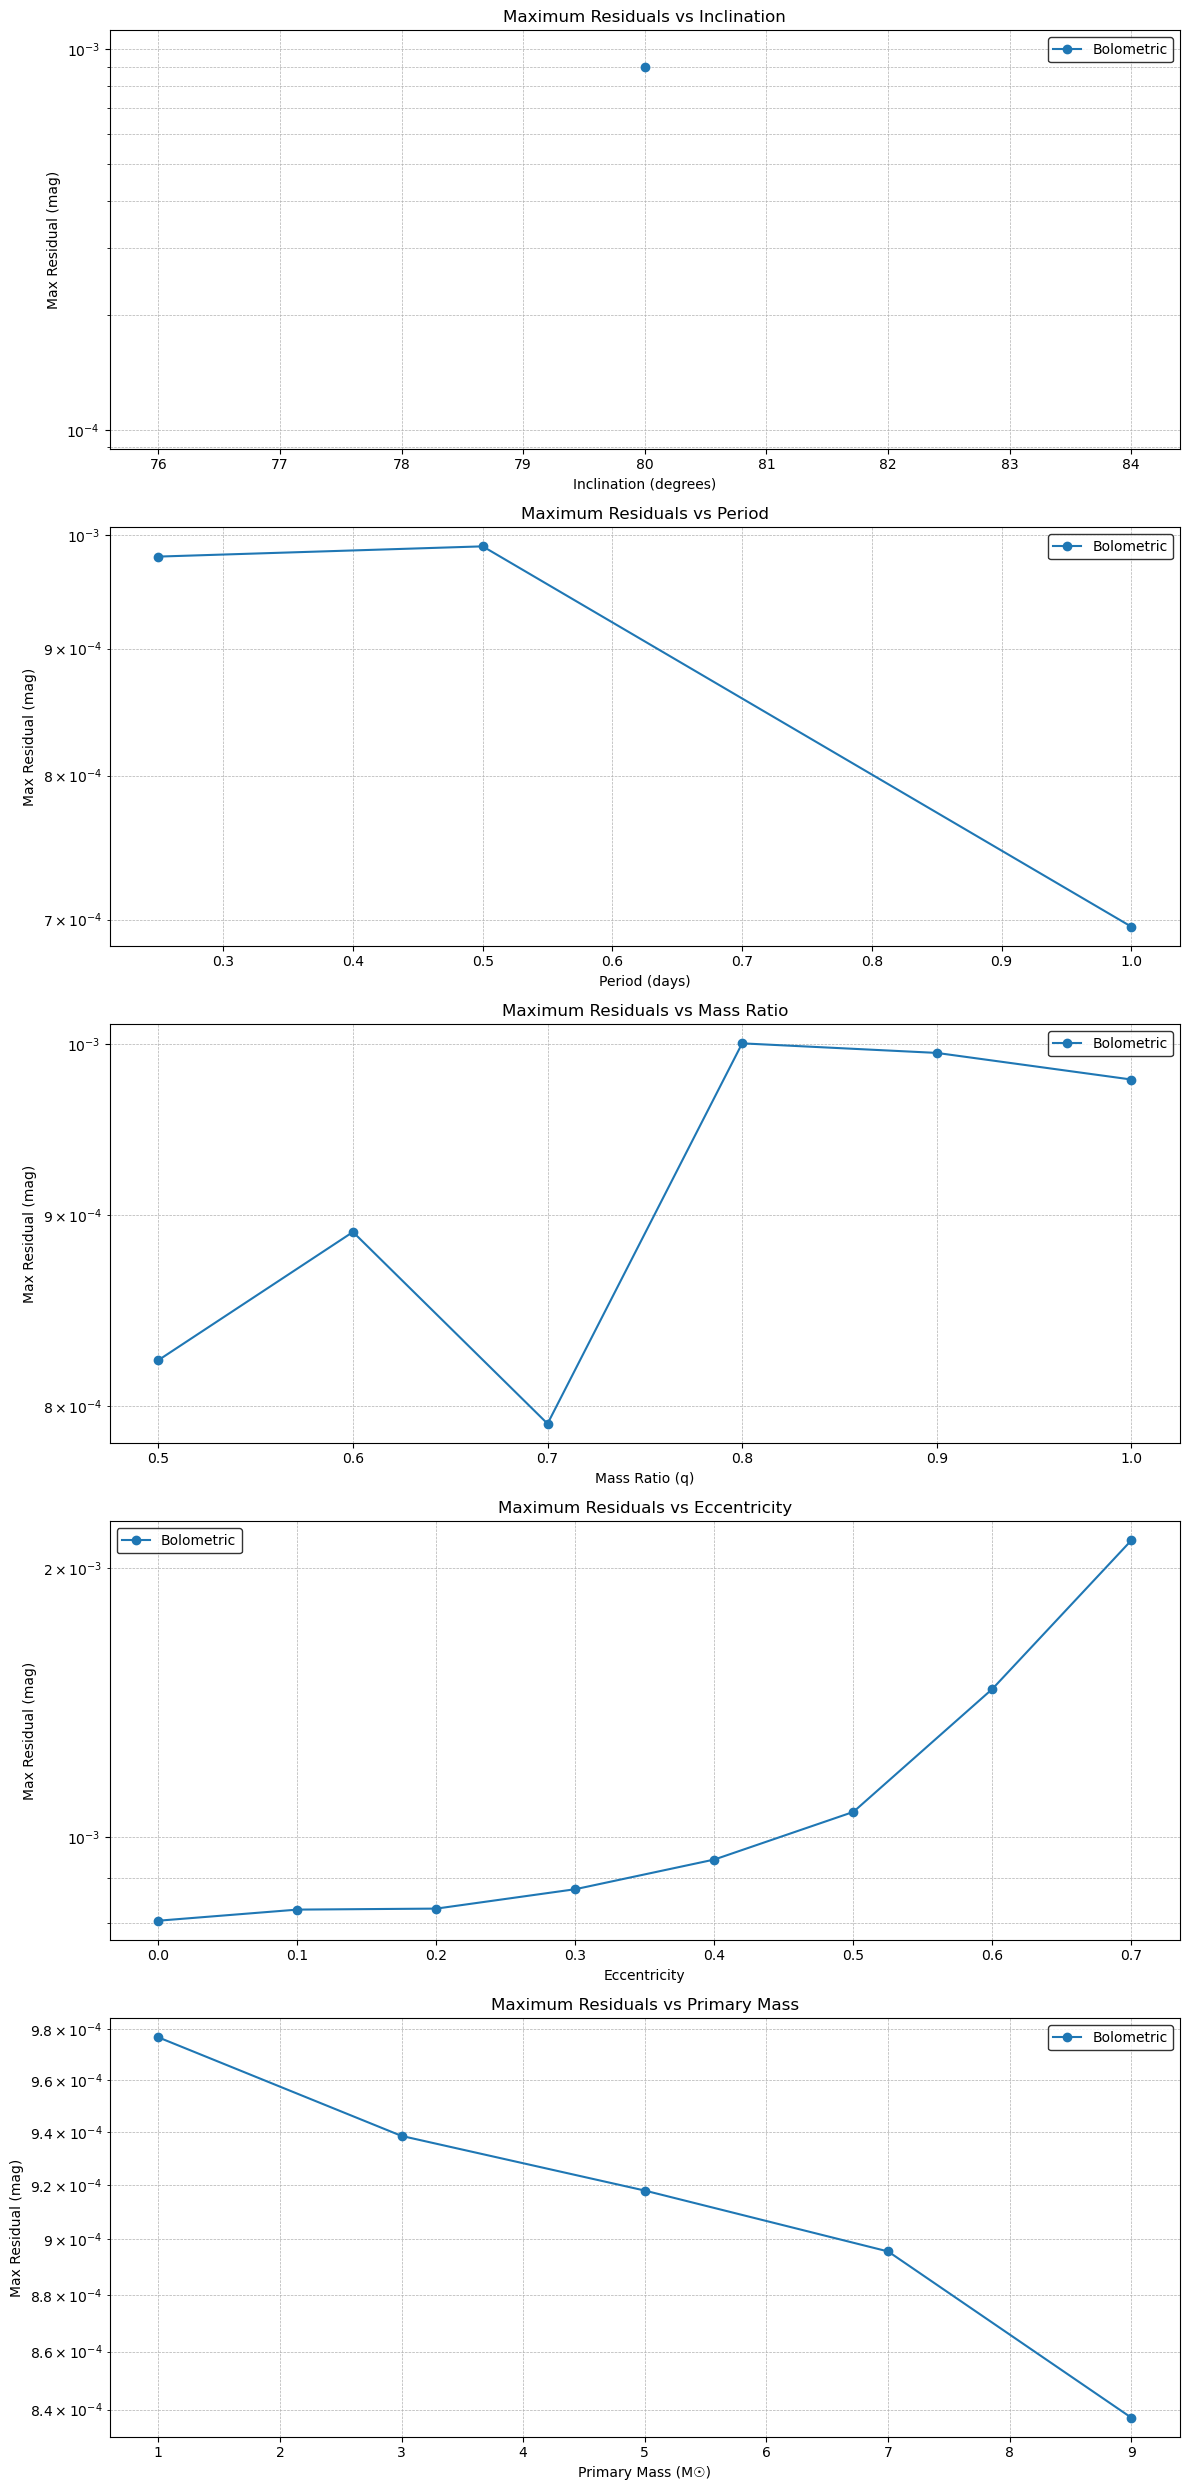

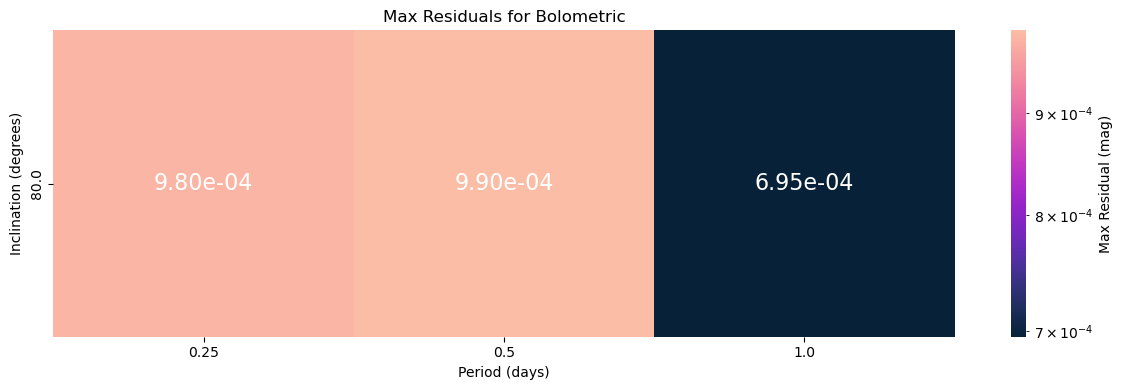

Summary of maximum residuals by filter:
                mean       std       min       max
Filter                                            
Bolometric  0.000898  0.000326  0.000142  0.002728

Top 10 parameter combinations with largest residuals:
         Filter  Inclination  Period  Mass Ratio  Eccentricity  Primary Mass  \
281  Bolometric         80.0     1.0         0.6           0.7           7.0   
83   Bolometric         80.0     1.0         0.6           0.7           9.0   
211  Bolometric         80.0     0.5         1.0           0.6           9.0   
288  Bolometric         80.0     1.0         0.5           0.7           9.0   
3    Bolometric         80.0     0.5         0.9           0.6           9.0   
120  Bolometric         80.0     0.5         0.8           0.6           9.0   
194  Bolometric         80.0     1.0         0.6           0.6           3.0   
254  Bolometric         80.0     0.5         1.0           0.5           5.0   
113  Bolometric         80.0    

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from matplotlib.colors import LogNorm
import cmasher as cmr
import pickle
import pandas as pd

# Function to extract parameters from filename
def extract_params_from_filename(filename):
    # Example: eclipses_incl_90.0_period_1.0_q_1.0_ecc_0.0_primary_mass_1.0.pkl
    base = os.path.basename(filename)
    parts = base.replace('.pkl', '').split('_')
    incl = float(parts[2])
    period = float(parts[4])
    q = float(parts[6])
    ecc = float(parts[8])
    primary_mass = float(parts[11])
    return incl, period, q, ecc, primary_mass

# Find all result files
result_files = glob.glob('scr_mk27/eclipse_grid_20000_vbig/eclipses_incl_*.pkl')

# Collect all max residuals
all_data = []

for file_path in result_files:
    incl, period, q, ecc, primary_mass = extract_params_from_filename(file_path)
    # if incl == 80.0 or period<0.25:
    #     continue
    with open(file_path, 'rb') as f:
        try:
            data = pickle.load(f)
            # Each file contains: 'fluxes_phoebe', 'bol_lum', 'times', etc.
            # We can compute the max residual for each filter (if multi-filter, but here it's bolometric)
            # For this example, we assume only bolometric
            # If you have multiple filters, adapt accordingly
            # Compute max absolute residual between PHOEBE and SPICE
            fluxes_phoebe = np.array(data['fluxes_phoebe'])
            mags_phoebe = -2.5 * np.log10(fluxes_phoebe / 2.5e8)
            mags_phoebe = mags_phoebe - mags_phoebe[0]
            bol_lum = np.array(data['bol_lum'])
            bol_lum = bol_lum - bol_lum[0]
            times = np.array(data['times'])
            max_residual = np.max(np.abs(mags_phoebe - bol_lum))
            # If you want to keep all residuals, you could store them as well
            all_data.append({
                'Max Residual': max_residual,
                'Inclination': incl,
                'Period': period,
                'Mass Ratio': q,
                'Eccentricity': ecc,
                'Primary Mass': primary_mass,
                'Filter': 'Bolometric'
            })
        except:
            continue

# Convert to DataFrame
results_df = pd.DataFrame(all_data)

# Create a figure with subplots for each parameter
fig, axes = plt.subplots(5, 1, figsize=(12, 25))
parameters = ['Inclination', 'Period', 'Mass Ratio', 'Eccentricity', 'Primary Mass']
param_labels = ['Inclination (degrees)', 'Period (days)', 'Mass Ratio (q)', 'Eccentricity', 'Primary Mass (M☉)']

for i, (param, label) in enumerate(zip(parameters, param_labels)):
    ax = axes[i]
    # Group by parameter and filter, then get the mean max residual
    grouped = results_df.groupby([param, 'Filter'])['Max Residual'].mean().reset_index()
    # Plot for each filter
    for filter_name in grouped['Filter'].unique():
        filter_data = grouped[grouped['Filter'] == filter_name]
        ax.plot(filter_data[param], filter_data['Max Residual'], 'o-', label=filter_name)
    ax.set_xlabel(label)
    ax.set_ylabel('Max Residual (mag)')
    ax.set_yscale('log')
    ax.set_title(f'Maximum Residuals vs {param}')
    legend = ax.legend(facecolor='white', edgecolor='black')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('max_residuals_by_parameter.png', dpi=300, bbox_inches='tight')
plt.show()

# Create heatmaps for pairs of parameters
# We'll focus on inclination vs period for each filter
filters = results_df['Filter'].unique()

fig, axes = plt.subplots(len(filters), 1, figsize=(12, 4*len(filters)))
if len(filters) == 1:
    axes = [axes]

for i, filter_name in enumerate(filters):
    filter_data = results_df[results_df['Filter'] == filter_name]
    # Create pivot table for inclination vs period
    pivot = filter_data.pivot_table(
        index='Inclination', 
        columns='Period', 
        values='Max Residual',
        aggfunc='mean'
    )
    # Plot heatmap
    heatmap = sns.heatmap(pivot, cmap=cmr.bubblegum, norm=LogNorm(), ax=axes[i], cbar_kws={'label': 'Max Residual (mag)'})
    # Add annotations with scientific notation in white
    for j in range(len(pivot.index)):
        for k in range(len(pivot.columns)):
            if not pd.isna(pivot.iloc[j, k]):
                axes[i].text(k + 0.5, j + 0.5, f'{pivot.iloc[j, k]:.2e}',
                           ha="center", va="center", color="white", fontsize=16)
    axes[i].set_title(f'Max Residuals for {filter_name}')
    axes[i].set_xlabel('Period (days)')
    axes[i].set_ylabel('Inclination (degrees)')

plt.tight_layout()
plt.savefig('max_residuals_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("Summary of maximum residuals by filter:")
summary = results_df.groupby('Filter')['Max Residual'].agg(['mean', 'std', 'min', 'max'])
print(summary)

# Find the parameter combinations with the largest residuals
print("\nTop 10 parameter combinations with largest residuals:")
top_residuals = results_df.sort_values('Max Residual', ascending=False).head(10)
print(top_residuals[['Filter', 'Inclination', 'Period', 'Mass Ratio', 'Eccentricity', 'Primary Mass', 'Max Residual']])


In [19]:
# Save results_df to a CSV file
results_df.to_csv('phoebe_lc_check_results_20000.csv', index=False)

In [20]:
# Show max and median residuals per filter
print("\nMaximum and median residuals by filter:")
residual_stats = results_df.groupby('Filter')['Max Residual'].agg(['max', 'median'])
print(residual_stats)



Maximum and median residuals by filter:
                 max   median
Filter                       
Bolometric  0.002728  0.00093


In [21]:
sample_result_file = pickle.load(open(glob.glob('scr_mk27/eclipse_grid_20000_vbig/eclipses_incl_*.pkl')[2], 'rb'))

EOFError: Ran out of input

In [ ]:
sample_result_file['phoebe_binary'].filter(kind='mesh', context='model').qualifiers

['times',
 'uvw_elements',
 'uvw_normals',
 'xyz_elements',
 'xyz_normals',
 'volume',
 'xs',
 'ys',
 'zs',
 'vxs',
 'vys',
 'vzs',
 'nxs',
 'nys',
 'nzs',
 'us',
 'vs',
 'ws',
 'vus',
 'vvs',
 'vws',
 'nus',
 'nvs',
 'nws',
 'areas',
 'rs',
 'loggs',
 'teffs',
 'rprojs',
 'mus',
 'visible_centroids',
 'visibilities']

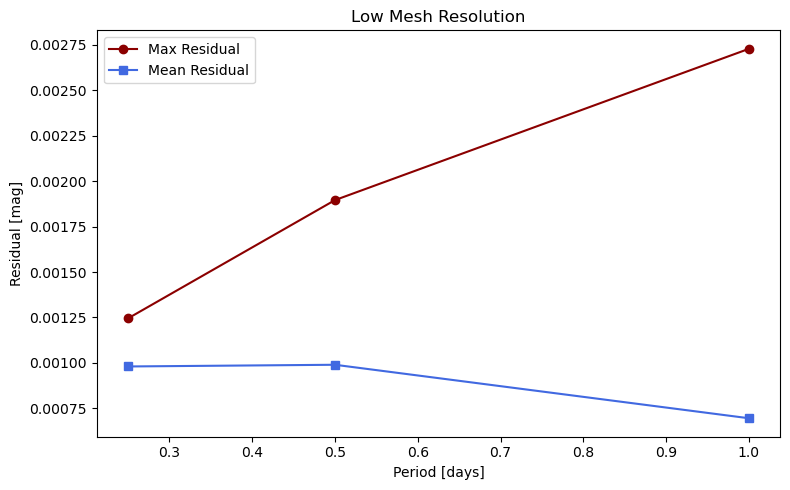

In [22]:
# Plot max and mean residuals per period

# Group by Period and compute max and mean residuals
period_stats = results_df.groupby('Period')['Max Residual'].agg(['max', 'mean']).reset_index()

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot max residuals
ax1.plot(period_stats['Period'], period_stats['max'], marker='o', label='Max Residual', color='darkred')
# Plot mean residuals
ax1.plot(period_stats['Period'], period_stats['mean'], marker='s', label='Mean Residual', color='royalblue')

ax1.set_xlabel('Period [days]')
ax1.set_ylabel('Residual [mag]')
# ax1.set_yscale('log')
ax1.set_title('Low Mesh Resolution')
ax1.legend()
plt.tight_layout()
plt.savefig('residuals_per_period_20000.png', dpi=300, bbox_inches='tight')
plt.show()

HIGH-RES: 22538

MEDIUM-RES: 5806

LOW-RES: 1142